In [2]:
import pulse_simulator as ps
import functools
import qiskit_dynamics as qk_d
import qiskit.providers.fake_provider as qk_fp
import numpy as np
import csv
import qiskit
import matplotlib.pyplot as plt

from qiskit.quantum_info import Operator, process_fidelity

/Users/epelaezc/Desktop/Research/pulse-simulator/.venv/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [3]:
import sys
sys.path.append("../")
from pulse_simulator.simulator import Simulator
import pulse_simulator as ps

In [4]:
backend = qk_fp.FakeManila()
units = 1e9
ns = units
dt = backend.configuration().dt * ns

In [309]:
registers = [i for i in range(2)]
config_vars = ps.backend_simulation_vars(backend, rabi=False, units=units)

H_rx = functools.partial(
    ps.rx_model,
    registers=registers,
    backend=backend,
    variables=config_vars,
    rotating_frame=True,
)

Hs_control = []
Hs_channels = []
for qubit in registers:
    Hj_drift, Hjs_control, Hjs_channel = H_rx(qubit)
    Hs_control += Hjs_control
    Hs_channels += Hjs_channel

In [410]:
good_pulses = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_R1e-3.csv"
default_pulses = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_default.csv"

In [411]:
def get_simulated_fidelity(sim, qc, file_name):
    gates = []
    with open(file_name) as file:
        reader = csv.reader(file)
        for row in reader:
            gates.append(np.array([float(x) for x in row]))

    # expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
    # for i in range(len(gates)):
    #     normalization = np.trapz(gates[i], dx=dt) / expected_angles[i]
    #     gates[i] = gates[i] / normalization

    for pulse, name in zip(gates, ["x_blue", "x_red", "sx_blue", "sx_red"]):
        pulse = qiskit.pulse.Waveform(pulse, limit_amplitude=False)
        sim.set_pulse(name, pulse)

    expected = Operator(qc)
    out = sim.simulate_circuit(qc)
    return process_fidelity(out, expected)

In [412]:
qc = qiskit.QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘

In [413]:
Hs_control

[Operator([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
           [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
           [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
           [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
          input_dims=(2, 2), output_dims=(2, 2)),
 Operator([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
           [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
           [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
           [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
          input_dims=(2, 2), output_dims=(2, 2))]

In [414]:
Hs_channels

['d0', 'd1']

In [467]:
default_fidelities = []
good_fidelities = []
strength_array = np.arange(0, 0.025, 0.001)

for strength in strength_array:
    # testing ζ Z Z + u(t) X X
    Z_op = np.array([[1, 0], [0, -1]])

    solver = qk_d.Solver(
        # static_hamiltonian=Z_op * strength,
        static_hamiltonian=qiskit.quantum_info.Operator(np.kron(Z_op, Z_op) * strength),
        hamiltonian_operators=Hs_control,
        static_dissipators=None,
        rotating_frame=None,
        rwa_cutoff_freq=None,
        hamiltonian_channels=Hs_channels,
        channel_carrier_freqs={ch: 0.0 for ch in Hs_channels},
        dt=dt,
    )

    sim = ps.simulator.Simulator(
        basis_gates=["rz", "sx", "x", "cx"], solver=solver, backend=backend
    )

    default_fidelities.append(1 - get_simulated_fidelity(sim, qc, default_pulses))
    good_fidelities.append(1 - get_simulated_fidelity(sim, qc, good_pulses))

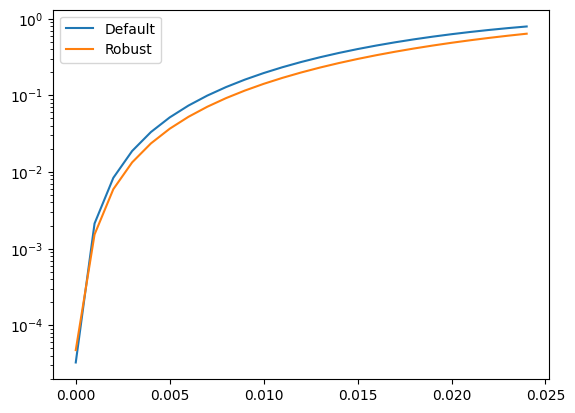

In [468]:
plt.plot(strength_array, default_fidelities, label="Default")
plt.plot(strength_array, good_fidelities, label="Robust")
plt.yscale("log")
plt.legend();

### Qutip

In [419]:
import qutip

In [420]:
I = np.array([[1, 0], 
              [0, 1]], dtype="complex128")
Z = np.array([[1, 0], 
              [0, -1]], dtype="complex128")
X = np.array([[0, 1], 
              [1, 0]], dtype="complex128")

# 1 qubit
# if Hj_drift == 0:
#     H_t_ind = 0 * qutip.Qobj(I)
# else:
#     H_t_ind = qutip.Qobj(Hj_drift.data)
# H_t_ind += 0.001 * qutip.Qobj(Z)

# 2 qubit
if Hj_drift == 0:
    H_t_ind = 0 * qutip.Qobj(np.kron(I, I))
else:
    H_t_ind = qutip.Qobj(Hj_drift.data)
H_t_ind += 0.01 * qutip.Qobj(np.kron(Z, Z))

In [453]:
times = np.linspace(0.0, 11.11, 50)
# times

In [454]:
robust_gates = []
default_gates = []

with open(good_pulses) as file:
    reader = csv.reader(file)
    for row in reader:
        robust_gates.append(np.array([float(x) for x in row]))

with open(default_pulses) as file:
    reader = csv.reader(file)
    for row in reader:
        default_gates.append(np.array([float(x) for x in row]))


# expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
# for i in range(len(robust_gates)):
#     normalization = np.trapz(robust_gates[i], dx=dt) / expected_angles[i]
#     robust_gates[i] = robust_gates[i] / normalization

# expected_angles = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]
# for i in range(len(default_gates)):
#     normalization = np.trapz(default_gates[i], dx=dt) / expected_angles[i]
#     default_gates[i] = default_gates[i] / normalization

x_blue_default = default_gates[0]
x_red_default = default_gates[1]

x_blue_robust = robust_gates[0]
x_red_robust = robust_gates[1]

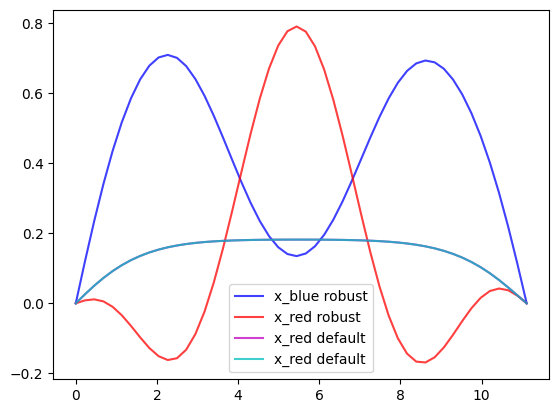

In [455]:
plt.plot(times, x_blue_robust, color="blue", label="x_blue robust", alpha=0.75)
plt.plot(times, x_red_robust, color="red", label="x_red robust", alpha=0.75)
plt.plot(times, x_red_default, color="m", label="x_red default", alpha=0.75)
plt.plot(times, x_blue_default, color="c", label="x_red default", alpha=0.75)
plt.legend();

In [456]:
H_0_control = qutip.Qobj(Hs_control[0].data)
H_1_control = qutip.Qobj(Hs_control[1].data)
H = [H_t_ind, [H_0_control, x_blue_default], [H_1_control, x_red_default]]
psi0 = qutip.Qobj(np.kron(I, I))

result = qutip.sesolve(H=H, psi0=psi0, tlist=times)

In [457]:
expected = qutip.Qobj(np.kron(X, X))

In [458]:
np.abs(np.real((result.states[-1].dag() * expected).tr() / 4))

0.9805297007473219

In [463]:
np.arange(0, 50) * 2/ 9

array([ 0.        ,  0.22222222,  0.44444444,  0.66666667,  0.88888889,
        1.11111111,  1.33333333,  1.55555556,  1.77777778,  2.        ,
        2.22222222,  2.44444444,  2.66666667,  2.88888889,  3.11111111,
        3.33333333,  3.55555556,  3.77777778,  4.        ,  4.22222222,
        4.44444444,  4.66666667,  4.88888889,  5.11111111,  5.33333333,
        5.55555556,  5.77777778,  6.        ,  6.22222222,  6.44444444,
        6.66666667,  6.88888889,  7.11111111,  7.33333333,  7.55555556,
        7.77777778,  8.        ,  8.22222222,  8.44444444,  8.66666667,
        8.88888889,  9.11111111,  9.33333333,  9.55555556,  9.77777778,
       10.        , 10.22222222, 10.44444444, 10.66666667, 10.88888889])

In [470]:
robust_fidelities = []
default_fidelities = []
strength_array = np.arange(0, 0.025, 0.001)

ZZ_op = qutip.Qobj(np.kron(Z, Z))
H_0_control = qutip.Qobj(Hs_control[0].data)
H_1_control = qutip.Qobj(Hs_control[1].data)
psi0 = qutip.Qobj(np.kron(I, I))

times = np.arange(0, 50) * 2/ 9

for strength in strength_array:
    # testing ζ Z Z + u_1 (t) I X + u_2 (t) X I
    if Hj_drift == 0:
        H_t_ind = 0 * qutip.Qobj(np.kron(I, I))
    else:
        H_t_ind = qutip.Qobj(Hj_drift.data)
    H_t_ind += strength * ZZ_op

    H_default = [H_t_ind, [H_0_control, x_blue_default], [H_1_control, x_red_default]]
    H_robust = [H_t_ind, [H_0_control, x_blue_robust], [H_1_control, x_red_robust]]

    default_result = qutip.sesolve(H=H_default, psi0=psi0, tlist=times)
    robust_result = qutip.sesolve(H=H_robust, psi0=psi0, tlist=times)

    default_fidelities.append(np.abs(np.real((default_result.states[-1].dag() * expected).tr() / 4)))
    robust_fidelities.append(np.abs(np.real((robust_result.states[-1].dag() * expected).tr() / 4)))

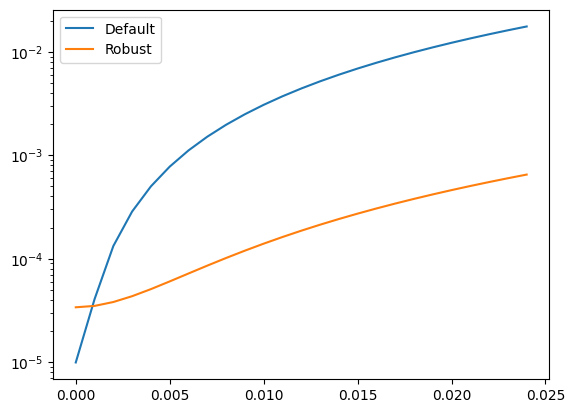

In [471]:
plt.plot(strength_array, 1 - np.array(default_fidelities), label="Default")
plt.plot(strength_array, 1 - np.array(robust_fidelities), label="Robust")
plt.yscale("log")
plt.legend();